# Cookie Model

Anna Letcher Hartman and Olivia Seitelman

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

In [2]:
%psource linrange

# To Do:
dunk eq in run simulation

bake cookies
find T_init
calc heat transfer rate (r)
best dunk time

## Code from previous notebooks

The update function models the cooling of a cookie when exposed to air. It uses Newton's Law of Cooling to model the interaction of the surface of the cookie and the heat it loses to the environment.

In [3]:
def update_func(state, t, system):
    """Update the thermal transfer model.
    
    state: State (temp)
    t: time
    system: System object
    
    returns: State (temp)
    """
    unpack(system)
    
    T = state.T
    T += -r * (T - T_env) * dt
    
    return State(T=T)

The run simulation function is the same function we have previously used. It creates a TimeFrame and uses a for loop to call the update function with a different values of t at every increment dt.

In [4]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
    
    Add a TimeFrame to the System: results
    
    system: System object
    update_func: function that updates state
    """
    unpack(system)
    
    frame = TimeFrame(columns=init.index)
    frame.row[0] = init
    ts = linrange(0, t_end, dt)
    
    for t in ts:
        frame.row[t+dt] = update_func(frame.row[t], t, system)
        
    # store the final temperature in T_final
    system.T_final = get_last_value(frame.T)
    
    return frame

Make system creates a system with set values for environmental factors and variable values for the initial temperature, the heat transfer rate `r`, and `t_end`.

In [33]:
def make_system(T_init, r, t_end):
    """Makes a System object with the given parameters.

    T_init: initial temperature in degrees C
    T_env: air temp
    r: heat transfer rate, in 1/min
    
    returns: System object
    """
    init = State(T=T_init)
    
    # T_final is used to store the final temperature.
    # Before the simulation runs, T_final = T_init
    T_final = T_init

    T_env = 25
    T_milk = 5
    dt = .1
    t_0 = 0
                
    return System(locals())

In [34]:
system = make_system(170, 0.01, 10)

,values
t_0,0
dt,0.1
T_milk,5
T_env,25
T_final,170
init,T 170 dtype: int64
t_end,10
r,0.01
T_init,170


We want to find the value of `r` that makes the final temperature 37, so we define an "error function" that takes `r` as a parameter and returns the difference between the final temperature and the goal.

In [7]:
def error_func1(r):
    """Runs a simulation and returns the `error`.
    
    r: heat transfer rate, in 1/min
    
    returns: difference between final temp and 70 C
    """
    system = make_system(T_init=170, r=r, t_end=10)
    results = run_simulation(system, update_func)
    return system.T_final - 37

We run the error function with varying values of `r` to find the correct heat transfer rate.

In [8]:
error_func1(r=0.01)

119.19486133148774

In [9]:
error_func1(r=0.03)

95.37021763326857

In [10]:
error_func1(r=0.1)

41.074689484618304

In [11]:
error_func1(r=0.3)

-5.104886350816177

In [12]:
error_func1(r=0.25)

-0.46999297003441853

In [13]:
error_func1(r=0.245)

0.13655351710209374

The best value of r is 0.245

The return value from `fsolve` is an array with a single element, the estimated value of `r`.

In [14]:
solution = fsolve(error_func1, 0.245)
r_cookie = solution[0]
r_cookie

0.24610373538455288

If we run the simulation with the estimated value of `r`, the final temperature is 37 C, as expected.

In [15]:
cookie = make_system(T_init=170, r=r_cookie, t_end=10)
results = run_simulation(cookie, update_func)
cookie.T_final

37.0000000001324

### Dunk Function 


use newton's law of cooling bc dunking in milk env

In [35]:
def dunk_func(state, t, system):
    """Simulates the dunking of cookie into milk.
    
    state: State (temp)
    t: time
    system: System object
    
    returns: State (temp)
    """
    unpack(system)
    
    T = state.T
    T += -r * (T - T_milk) * dt
    
    return State(T=T)

In [36]:
results = run_simulation (cookie, update_func)
results.head()

,T
0.0,170
0.1,166.431
0.2,162.951
0.3,159.556
0.4,156.244


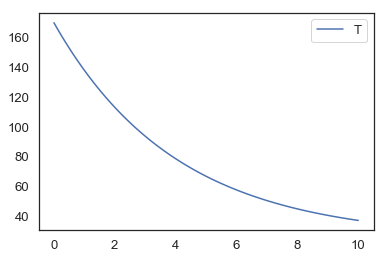

In [37]:
results.plot()

In [42]:
milk = make_system(T_init=170, r=r_cookie, t_end=.2)
results = run_simulation (milk, dunk_func)
results.head()

,T
0.0,170
0.1,165.939
0.2,161.979


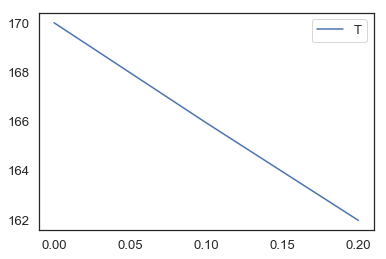

In [43]:
results.plot()

## Mixing at the end

First we'll see what happens if we add the milk at the end.  We'll simulate the coffee and the milk separately.

In [ ]:
coffee = make_system(T_init=90, t_end=30, r=r_coffee, volume=300)
coffee_results = run_simulation(coffee, update_func)
coffee.T_final

In [ ]:
milk = make_system(T_init=5, t_end=30, r=r_milk, volume=50)
milk_results = run_simulation(milk, update_func)
milk.T_final

Here's what the results look like.

In [ ]:
plot(coffee_results.T, label='coffee')
plot(milk_results.T, '--', label='milk')

decorate(xlabel='Time (minutes)',
         ylabel='Temperature (C)',
         loc='center left')

savefig('figs/chap07-fig01.pdf')

Here's what happens when we mix them.

In [ ]:
mix_last = mix(coffee, milk)
mix_last.T_final

## Mixing immediately

Next here's what we get if we add the milk immediately.

In [ ]:
coffee = make_system(T_init=90, t_end=0, r=r_coffee, volume=300)
milk = make_system(T_init=5, t_end=0, r=r_milk, volume=50)

In [ ]:
mix_first = mix(coffee, milk)
mix_first.t_end = 30
results = run_simulation(mix_first, update_func)
mix_first.T_final

The following function takes `t_add`, which is the time when the milk is added, and returns the final temperature.

In [ ]:
def run_and_mix(t_add, t_total):
    """Simulates two liquids and them mixes them at t_add.
    
    t_add: time in minutes
    t_total: total time to simulate, min
    
    returns: final temperature
    """
    coffee = make_system(T_init=90, t_end=t_add, 
                         r=r_coffee, volume=300)
    coffee_results = run_simulation(coffee, update_func)

    milk = make_system(T_init=5, t_end=t_add, 
                       r=r_milk, volume=50)
    milk_results = run_simulation(milk, update_func)
    
    mixture = mix(coffee, milk)
    mixture.t_end = t_total - t_add
    results = run_simulation(mixture, update_func)

    return mixture.T_final

We can try it out with a few values.

In [ ]:
run_and_mix(t_add=0, t_total=30)

In [ ]:
run_and_mix(t_add=15, t_total=30)

In [ ]:
run_and_mix(t_add=30, t_total=30)

And then sweep a range of values for `t_add`

In [ ]:
sweep = SweepSeries()
for t_add in linspace(0, 30, 11):
    sweep[t_add] = run_and_mix(t_add, 30)

Here's what the result looks like.

In [ ]:
plot(sweep, label='final temp', color='C2')
decorate(xlabel='Time added (min)',
         ylabel='Final temperature (C)')

savefig('figs/chap07-fig02.pdf')

### Analysis

Now we can use the analytic result to compute temperature as a function of time.  The following function is similar to `run_simulation`.

In [ ]:
def run_analysis(system):
    """Computes temperature using the analytic solution.
        
    system: System object
    
    returns: TimeFrame
    """
    unpack(system)
    
    T_init = init.T    
    ts = linrange(0, t_end, dt)
    
    T_array = T_env + (T_init - T_env) * exp(-r * ts)
    
    # to be consistent with run_simulation, we have to
    # put the array into a TimeFrame
    results = TimeFrame(T_array, index=ts, columns=['T'])
    system.T_final = get_last_value(results.T)

    return results

Here's how we run it.  From the analysis (see `chap14analysis.ipynb`), we have the computed value of `r_coffee2`

In [ ]:
r_coffee2 = 0.011610223142273859
coffee2 = make_system(T_init=90, r=r_coffee2, volume=300, t_end=30)
results = run_analysis(coffee2)
coffee2.T_final

And we can compare to the results from simulation.

In [ ]:
coffee = make_system(T_init=90, r=r_coffee, volume=300, t_end=30)
results = run_simulation(coffee, update_func)
coffee.T_final

They are identical except for a small roundoff error.

In [ ]:
coffee.T_final - coffee2.T_final